In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import lightgbm as lgbm
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle

In [2]:
columns0 = ['year','month','avgTa','maxTa','minTa','sumRn','avgWs','avgRhm','sumSsHr','avgPs','fp_patients']
df0 = pd.read_csv('csv/fp-weather.csv', names=columns0)
df0.head()

,year,month,avgTa,maxTa,minTa,sumRn,avgWs,avgRhm,sumSsHr,avgPs,fp_patients
0,2002,3,7.6,19.4,-2.9,31.5,2.1,55.0,128.6,1016.8,99
1,2002,4,13.6,27.7,4.3,155.1,2.3,53.0,172.4,1014.5,36
2,2002,5,18.2,27.7,10.0,58.0,2.3,62.0,175.0,1011.7,13
3,2002,6,22.2,32.0,14.5,61.4,2.0,62.0,162.9,1007.6,49
4,2002,7,25.2,34.8,18.9,220.6,2.1,74.0,84.1,1004.5,17


In [3]:
df0.to_csv('csv/fp-weather-add-column.csv',index=False)

In [4]:
columns1 = ['avgTa','maxTa','minTa','sumRn','avgWs','avgRhm','sumSsHr','avgPs','fp_patients']
df1 = df0[columns1]
df1.head()

,avgTa,maxTa,minTa,sumRn,avgWs,avgRhm,sumSsHr,avgPs,fp_patients
0,7.6,19.4,-2.9,31.5,2.1,55.0,128.6,1016.8,99
1,13.6,27.7,4.3,155.1,2.3,53.0,172.4,1014.5,36
2,18.2,27.7,10.0,58.0,2.3,62.0,175.0,1011.7,13
3,22.2,32.0,14.5,61.4,2.0,62.0,162.9,1007.6,49
4,25.2,34.8,18.9,220.6,2.1,74.0,84.1,1004.5,17


In [5]:
print('DataFrame Shape : {}'.format(df1.shape))
print('Sum of Duplicated Data : {}'.format(df1.duplicated().sum()))
print('Sum of Null Data : {}'.format(df1.isnull().sum().sum()))

DataFrame Shape : (208, 9)
Sum of Duplicated Data : 0
Sum of Null Data : 0


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avgTa        208 non-null    float64
 1   maxTa        208 non-null    float64
 2   minTa        208 non-null    float64
 3   sumRn        208 non-null    float64
 4   avgWs        208 non-null    float64
 5   avgRhm       208 non-null    float64
 6   sumSsHr      208 non-null    float64
 7   avgPs        208 non-null    float64
 8   fp_patients  208 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 14.8 KB


In [7]:
train, test = train_test_split(df1, test_size=0.25, random_state=42)
print('분리전 데이터 : {}\n'.format(df1.shape))
print('훈련 데이터 : {}'.format(train.shape))
print('테스트 데이터 : {}'.format(test.shape))

분리전 데이터 : (208, 9)

훈련 데이터 : (156, 9)
테스트 데이터 : (52, 9)


In [8]:
target = 'fp_patients'
features = df1.columns.drop(target)

X_train =  train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print('X y 분리 후 shape\n')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))
print('\nX_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))

X y 분리 후 shape

X_train : (156, 8)
y_train : (156,)

X_test : (52, 8)
y_test : (52,)


In [9]:
baseline = [y_train.mean()] * len(y_train)
baseline_mse = mean_squared_error(y_train, baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_train, baseline))
baseline_mae = mean_absolute_error(y_train, baseline)
print('Baseline mean : {}'.format(y_train.mean()))
print('Baseline MSE : {}'.format(baseline_mse))
print('Baseline RMSE : {}'.format(baseline_rmse))
print('Baseline MAE : {}'.format(baseline_mae))

Baseline mean : 103.72435897435898
Baseline MSE : 46863.85350920447
Baseline RMSE : 216.48060769779002
Baseline MAE : 113.04100920447075


In [10]:
train_ds = lgbm.Dataset(X_train, label= y_train)
test_ds = lgbm.Dataset(X_test, label= y_test)

param = {
    'boosting' : 'gbdt',
    'objective' : 'regression',
    'metric' : 'rmse',
    'seed' : 42,
    'is_training_metric' : True,
    'max_depth' : 16,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.75,
    'bagging_fraction' : 0.8,
    'bagging_freq' : 16,
    'num_leaves' : 128,
    'verbosity' : -1
}

In [11]:
model_lgbm = lgbm.train(params=param,
                   train_set=train_ds,
                   num_boost_round=1000,
                   valid_sets=test_ds,
                   callbacks=[early_stopping(75),
                              log_evaluation(75)])

Training until validation scores don't improve for 75 rounds
[75]	valid_0's rmse: 120.443
[150]	valid_0's rmse: 123.299
Early stopping, best iteration is:
[93]	valid_0's rmse: 119.486


In [12]:
predict_train = model_lgbm.predict(X_train)
predict_test = model_lgbm.predict(X_test)

df_metrics = pd.DataFrame({'Baseline':[y_train.mean(),
                                   baseline_mse,
                                   baseline_rmse,
                                   baseline_mae],
                           'Train':[predict_train.mean(),
                                  mean_squared_error(y_train,predict_train),
                                  np.sqrt(mean_squared_error(y_train,predict_train)),
                                  mean_absolute_error(y_train,predict_train)],
                           'Test':[predict_test.mean(),
                                   mean_squared_error(y_test,predict_test),
                                   np.sqrt(mean_squared_error(y_test,predict_test)),
                                   mean_absolute_error(y_test,predict_test)]},
                          index = ['Mean','MSE','RMSE','MAE'])
df_metrics

,Baseline,Train,Test
Mean,103.724359,103.623099,117.324022
MSE,46863.853509,32435.952569,14276.814351
RMSE,216.480608,180.099841,119.485624
MAE,113.041009,95.300065,83.334405


In [13]:
df_metrics_plot = df_metrics.iloc[2:]
df_metrics_plot

,Baseline,Train,Test
RMSE,216.480608,180.099841,119.485624
MAE,113.041009,95.300065,83.334405


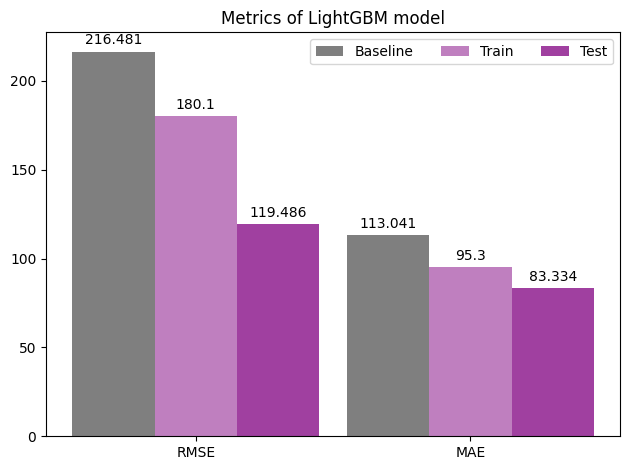

In [14]:
x = np.arange(2)
width = 0.3

fig, ax = plt.subplots()
rect1 = ax.bar(x-width, df_metrics_plot.Baseline.round(3), width, label='Baseline',color='black',alpha=0.5)
rect2 = ax.bar(x, df_metrics_plot.Train.round(3), width, label='Train',color='purple',alpha=0.5)
rect3 = ax.bar(x+width, df_metrics_plot.Test.round(3), width, label='Test',color='purple',alpha=0.75)

ax.set_title('Metrics of LightGBM model')
ax.set_xticks(x, df_metrics_plot.index)
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)
ax.bar_label(rect3, padding=3)

fig.tight_layout()

plt.legend(ncol=3)
plt.show()

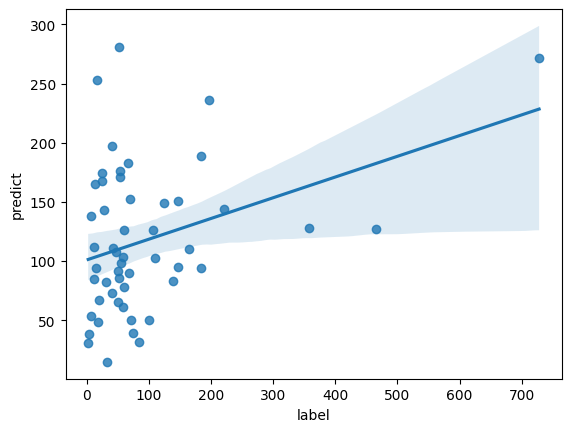

In [15]:
result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
result.columns = ['label','predict']
sns.regplot(x='label', y='predict', data=result)
plt.show()

In [16]:
with open('model.pkl', 'wb') as pf:
    pickle.dump(model_lgbm, pf)